In [1]:
import pandas as pd
import numpy as np
import re
import koreanize_matplotlib
import os
import platform

# 그래프에  retina display 적용
%config InlineBackend.figure_format = 'retina'

In [41]:
base_path = "data"
file_name = "petition.csv" 
url = "https://drive.google.com/open?id=1d8VEAj6n83wT1YRlCrhoU_1mMSvYpXc4"

petitions = pd.read_csv(f"{base_path}/petition.csv", parse_dates=['start', 'end'])
petitions.shape

(377756, 8)

In [42]:
petition_remove_outlier = petitions.loc[(petitions['votes'] > 500) & (petitions['votes'] < 200000)]
petition_remove_outlier.shape

(5109, 8)

In [43]:
df = petition_remove_outlier.copy()

df.describe()

,article_id,start,end,answered,votes
count,5109.000000,5109,5109,5109.0,5109.000000
mean,252208.264044,2018-05-27 11:11:22.795067392,2018-06-26 19:10:48.972401664,0.0,5674.709141
min,28.000000,2017-08-19 00:00:00,2017-08-26 00:00:00,0.0,501.000000
25%,145294.000000,2018-02-21 00:00:00,2018-03-23 00:00:00,0.0,771.000000
50%,242471.000000,2018-05-24 00:00:00,2018-06-23 00:00:00,0.0,1456.000000
75%,374255.000000,2018-09-10 00:00:00,2018-10-10 00:00:00,0.0,3794.000000
max,491954.000000,2019-01-09 00:00:00,2019-02-08 00:00:00,0.0,197343.000000
std,137485.014370,NaN,NaN,0.0,14334.261910


In [44]:
df.loc[df['answered'] == 1].shape

(0, 8)

<Axes: ylabel='Frequency'>

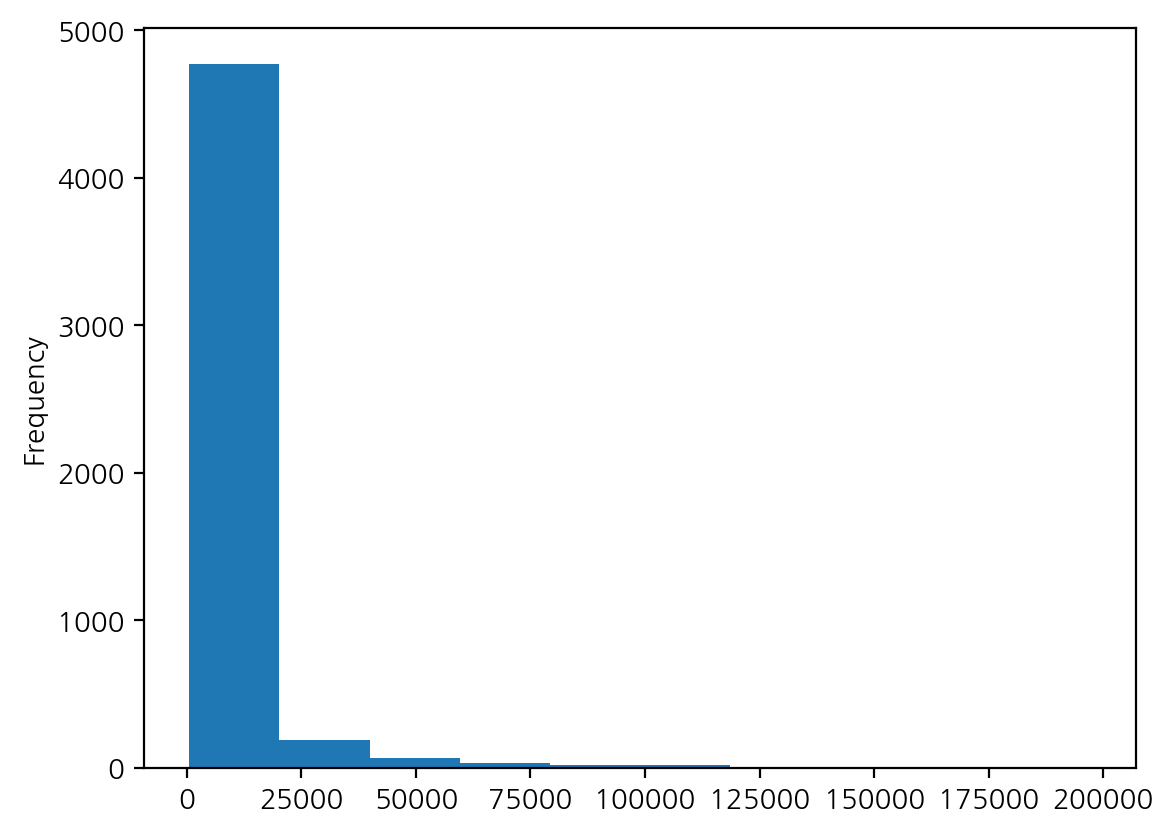

In [45]:
%matplotlib inline
df['votes'].plot.hist()

In [46]:
df['votes_pos_neg'] = 0
votes_mean = df['votes'].mean()
votes_mean

5674.709140732041

## 이번 장의 문제는 단어를 보고 투표율이 평균보다 높을 것인가? 아닌가? 를  
확인하는 것이다. 무슨 의미가 있는 것인지는 모르겠지만 `lightgbm`사용법을 배울 수 있다.

In [47]:

df['votes_pos_neg'] = (df['votes'] > votes_mean) == 1

In [48]:
df['votes_pos_neg'].dtypes

dtype('bool')

In [49]:
df['votes_pos_neg'] = df['votes_pos_neg'].astype(int)

In [50]:
df[['votes', 'votes_pos_neg']].head()

,votes,votes_pos_neg
7,2137,0
13,679,0
21,11293,1
24,1933,0
28,1251,0


In [51]:
df.head()

,article_id,start,end,answered,votes,category,title,content,votes_pos_neg
7,28,2017-08-19,2017-08-26,0,2137,경제민주화,소액주주를 보호해주십시오,** 존경하옵는 문재인대통령님께\n저는 중국원양자원이라는 KOSPI상장사의 소액 ...,0
13,34,2017-08-19,2017-09-18,0,679,기타,『국가유공자 등 예우 및 지원에 관한법률』상「6.25전몰군경 자녀수당」의 불합리한 ...,(현황)\n우리들 아버지께서는 67여년전 북의 남침으로 조국이 위기에 처했을 때 젊...,0
21,43,2017-08-19,2017-09-18,0,11293,육아/교육,기간제 교사의 정규직화를 반대합니다.,"대통령님, 안녕하세요. 저는 임용을 준비하고 수험생입니다. 처음 기간제 정규직화 된...",1
24,46,2017-08-19,2017-09-18,0,1933,육아/교육,기간제교사의 정규직화를 반대합니다.,"대통령님, 안녕하세요. 저는 임용을 준비하고 수험생입니다. 처음 기간제 정규직화 된...",0
28,50,2017-08-19,2017-10-18,0,1251,일자리,치과위생사 국가고시 날짜 변경 억울합니다,안녕하십니까? 대통령님 간단하게 제소개 부터 하겠습니다. 저는 치위생과 3학년 학생...,0


In [109]:
sample_index = 13
sample_title = df.loc[sample_index, 'title']
sample_title

'『국가유공자 등 예우 및 지원에 관한법률』상「6.25전몰군경 자녀수당」의 불합리한 문제점 개선 청원'

In [110]:
sample_content = petitions.loc[sample_index, 'content']
sample_content

'(현황)\\n우리들 아버지께서는 67여년전 북의 남침으로 조국이 위기에 처했을 때 젊은 목숨 을 바쳐 대한민국을 지켜내는데 헌신했습니다. 우리들 대부분의 아버님들 중 12만위는 전쟁 후 지금껏 유해도 수습 못했고 忌日도 제대로 알지 못하지만 오직 국가유공자의 자녀라는 자긍심으로 오랜 기간을 가난과 멸시 천대를 이겨왔습니다.\\n전후 원호제도는 빈약하여 전사자와 그 가족에 대한 보상과 연금 등은 너무 빈약했고,  그 후도 경제발전 수준을 따라가지도 못하였는데, 1960년대 말은 전쟁유자녀가 성년이 되었다는 이유로 보훈 보상혜택에서 제외시켰다가 김대중정부 시절 2001년7월부터 보훈제도가 확대되어 전후의 미흡했던 보훈혜택을 보전해주기 위해 1997년 12월31일을 기준으로 아래의 제적유자녀 1)와 승계유자녀 2)에게는 先順位자녀 1人에 대하여만「6ㆍ25전몰 군경자녀수당」을 지급하게 되었으나, 단서조항으로 1998년1월1일 이후 어머니 사망으로 연금수급권이 소멸되기 시작한 저희 유자녀들에 대하여는 동법 적용을 배제하여, 어머니 돌아가신 날 하루 차이로 “미수당유자녀” 아래표 3)라는 보훈정책의 사각지대가 생겨났던 것입니다.\\n신설된 수당과 유족연금이 노무현 정부이래 점차 현실화 인상 조정되고 이 문제가 장기간 누증되다보니\\n6.25전쟁에서 똑 같이 아버지가 전사한 군·경유자녀들인데, 누구는 국가의 지원을 받고 누구는 국가의 지원을 받지 못하는 형평성에 문제가 있는 『국가유공자 등 예우 및 지원에 관한 법률』제16조3(6.25자녀수당)의1,(단서조항 : 1998년 1월 1일을 삭제하는 법안)을 19대 국회에서 더민주당 민홍철 의원님(경남 김해)이 2014년 2월 대표발의 하시어 당시 여당의원 일부 반대의 우여곡절 끝에 전해철 법사위 소위원장님 등의 주도적 노력으로 2015년 11월30일 제337회 정기회에서 재석 의원 만장일치로 법이 통과되어 12월29일 법률 제13697호로 공포된바 있었습니다.\\n그럼에도 박근혜 정부는 동법 개정이유와 주요내용에서 입법부가 

In [112]:
def preprocessing(text):
    # 개행문자 제거
    text = re.sub('\\\\n', ' ', text)
    # 특수문자 제거
    # 특수문자나 이모티콘 등은 때로는 의미를 갖기도 하지만 여기에서는 제거했습니다.
    # text = re.sub('[?.,;:|\)*~`’!^\-_+<>@\#$%&-=#}※]', '', text)
    # 한글, 영문, 숫자만 남기고 모두 제거하도록 합니다.
    # text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z0-9]', ' ', text)
    # 한글, 영문만 남기고 모두 제거하도록 합니다.
    text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z]', ' ', text)
    # 중복으로 생성된 공백값을 제거합니다.
    text = re.sub(' +', ' ', text)
    return text

In [113]:
# 불용어 제거
def remove_stopwords(text):
    tokens = text.split(' ')
    stops = ['수', '현', '있는', '있습니다', '그', '년도', '합니다', '하는', 
             '및', '제', '할', '하고', '더', '대한', '한', '그리고', '월', 
             '저는', '없는', '입니다', '등', '일', '많은', '이런', '것은', 
             '왜','같은', '같습니다', '없습니다', '위해', '한다']
    meaningful_words = [w for w in tokens if not w in stops]
    return ' '.join(meaningful_words)

In [114]:
# 샘플데이터에 적용
%time 
pre_sample_content = preprocessing(sample_content)

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 3.81 µs


In [115]:
%time 
pre_sample_content = remove_stopwords(pre_sample_content)

CPU times: user 1e+03 ns, sys: 1 µs, total: 2 µs
Wall time: 3.1 µs


In [116]:
pre_sample_content

' 현황 우리들 아버지께서는 여년전 북의 남침으로 조국이 위기에 처했을 때 젊은 목숨 을 바쳐 대한민국을 지켜내는데 헌신했습니다 우리들 대부분의 아버님들 중 만위는 전쟁 후 지금껏 유해도 수습 못했고 도 제대로 알지 못하지만 오직 국가유공자의 자녀라는 자긍심으로 오랜 기간을 가난과 멸시 천대를 이겨왔습니다 전후 원호제도는 빈약하여 전사자와 가족에 보상과 연금 등은 너무 빈약했고 후도 경제발전 수준을 따라가지도 못하였는데 년대 말은 전쟁유자녀가 성년이 되었다는 이유로 보훈 보상혜택에서 제외시켰다가 김대중정부 시절 년 월부터 보훈제도가 확대되어 전후의 미흡했던 보훈혜택을 보전해주기 년 일을 기준으로 아래의 제적유자녀 와 승계유자녀 에게는 자녀 에 대하여만 전몰 군경자녀수당 을 지급하게 되었으나 단서조항으로 년 이후 어머니 사망으로 연금수급권이 소멸되기 시작한 저희 유자녀들에 대하여는 동법 적용을 배제하여 어머니 돌아가신 날 하루 차이로 미수당유자녀 아래표 라는 보훈정책의 사각지대가 생겨났던 것입니다 신설된 수당과 유족연금이 노무현 정부이래 점차 현실화 인상 조정되고 이 문제가 장기간 누증되다보니 전쟁에서 똑 같이 아버지가 전사한 군 경유자녀들인데 누구는 국가의 지원을 받고 누구는 국가의 지원을 받지 못하는 형평성에 문제가 국가유공자 예우 지원에 관한 법률 조 자녀수당 의 단서조항 년 일을 삭제하는 법안 을 대 국회에서 더민주당 민홍철 의원님 경남 김해 이 년 대표발의 하시어 당시 여당의원 일부 반대의 우여곡절 끝에 전해철 법사위 소위원장님 등의 주도적 노력으로 년 회 정기회에서 재석 의원 만장일치로 법이 통과되어 법률 호로 공포된바 있었습니다 그럼에도 박근혜 정부는 동법 개정이유와 주요내용에서 입법부가 제안한대로 특정일 기준 없이 전몰군경유자녀에게 자녀수당을 지급하도록 하여 자녀간 형평성을 도모함과 이들에 생활안정과 복지향상을 재고하려 고 밝히면서도 입법부의 개정 법률에 정면 위배되는 시행령 호 으로 천원 천원 천원이라는 불평등으로 호국영령의 명예와 최장 여년을 

In [57]:
%time
df['content_preprocessing'] = df['content'].apply(preprocessing)

CPU times: user 1 µs, sys: 1 µs, total: 2 µs
Wall time: 2.62 µs


In [58]:
%time
df['content_preprocessed'] = df['content_preprocessing'].apply(remove_stopwords)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.25 µs


In [59]:
df.head()

,article_id,start,end,answered,votes,category,title,content,votes_pos_neg,content_preprocessing,content_preprocessed
7,28,2017-08-19,2017-08-26,0,2137,경제민주화,소액주주를 보호해주십시오,** 존경하옵는 문재인대통령님께\n저는 중국원양자원이라는 KOSPI상장사의 소액 ...,0,존경하옵는 문재인대통령님께 저는 중국원양자원이라는 KOSPI상장사의 소액 주주입니...,존경하옵는 문재인대통령님께 중국원양자원이라는 KOSPI상장사의 소액 주주입니다 중...
13,34,2017-08-19,2017-09-18,0,679,기타,『국가유공자 등 예우 및 지원에 관한법률』상「6.25전몰군경 자녀수당」의 불합리한 ...,(현황)\n우리들 아버지께서는 67여년전 북의 남침으로 조국이 위기에 처했을 때 젊...,0,현황 우리들 아버지께서는 여년전 북의 남침으로 조국이 위기에 처했을 때 젊은 목숨...,현황 우리들 아버지께서는 여년전 북의 남침으로 조국이 위기에 처했을 때 젊은 목숨...
21,43,2017-08-19,2017-09-18,0,11293,육아/교육,기간제 교사의 정규직화를 반대합니다.,"대통령님, 안녕하세요. 저는 임용을 준비하고 수험생입니다. 처음 기간제 정규직화 된...",1,대통령님 안녕하세요 저는 임용을 준비하고 수험생입니다 처음 기간제 정규직화 된다고 ...,대통령님 안녕하세요 임용을 준비하고 수험생입니다 처음 기간제 정규직화 된다고 했을 ...
24,46,2017-08-19,2017-09-18,0,1933,육아/교육,기간제교사의 정규직화를 반대합니다.,"대통령님, 안녕하세요. 저는 임용을 준비하고 수험생입니다. 처음 기간제 정규직화 된...",0,대통령님 안녕하세요 저는 임용을 준비하고 수험생입니다 처음 기간제 정규직화 된다고 ...,대통령님 안녕하세요 임용을 준비하고 수험생입니다 처음 기간제 정규직화 된다고 했을 ...
28,50,2017-08-19,2017-10-18,0,1251,일자리,치과위생사 국가고시 날짜 변경 억울합니다,안녕하십니까? 대통령님 간단하게 제소개 부터 하겠습니다. 저는 치위생과 3학년 학생...,0,안녕하십니까 대통령님 간단하게 제소개 부터 하겠습니다 저는 치위생과 학년 학생입니다...,안녕하십니까 대통령님 간단하게 제소개 부터 하겠습니다 치위생과 학년 학생입니다 다름...


In [60]:
df.shape

(5109, 11)

In [61]:
split_count = int(df.shape[0]*0.7)
split_count

3576

In [62]:
df_train = df[:split_count].copy()
df_train.shape

(3576, 11)

In [63]:
df_train.tail(2)

,article_id,start,end,answered,votes,category,title,content,votes_pos_neg,content_preprocessing,content_preprocessed
264094,343167,2018-08-15,2018-09-14,0,22521,행정,여성가족부의 예산 사용 실적 공개를 촉구합니다,여성가족부의 예산 사용 실적 공개를 촉구합니다.\n여성가족부는 2001년 설립된 이...,1,여성가족부의 예산 사용 실적 공개를 촉구합니다 여성가족부는 년 설립된 이래 한번도 ...,여성가족부의 예산 사용 실적 공개를 촉구합니다 여성가족부는 년 설립된 이래 한번도 ...
264098,343171,2018-08-15,2018-09-14,0,860,보건복지,청각장애인 인공와우기계 보험적용부탁드립니다,저희 아이는 고도난청100데시벨이상으로 왼쪽 오른쪽 인공와우 수술을 하였습니다\n처...,0,저희 아이는 고도난청 데시벨이상으로 왼쪽 오른쪽 인공와우 수술을 하였습니다 처음은 ...,저희 아이는 고도난청 데시벨이상으로 왼쪽 오른쪽 인공와우 수술을 하였습니다 처음은 ...


In [64]:
df_train.loc[df_train['votes_pos_neg'] == 1].shape

(671, 11)

In [65]:
df_test = df[split_count:].copy()
df_test.shape

(1533, 11)

In [66]:
df_test.loc[df_test['votes_pos_neg'] == 1].shape

(273, 11)

In [71]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(analyzer = 'word', 
                             tokenizer = None, 
                             preprocessor = None,
                             stop_words = None, 
                             min_df =2, 
                             ngram_range=(1, 3), 
                             max_features = 2000)

In [73]:
%%time
train_feature_vector = vectorizer.fit_transform(df_train['content_preprocessed'])
train_feature_vector.shape

CPU times: user 8.61 s, sys: 516 ms, total: 9.13 s
Wall time: 9.12 s


(3576, 2000)

In [75]:
%%time
test_feature_vector = vectorizer.transform(df_test['content_preprocessed'])
test_feature_vector.shape

CPU times: user 572 ms, sys: 0 ns, total: 572 ms
Wall time: 571 ms


(1533, 2000)

In [77]:
vocab = vectorizer.get_feature_names_out()
print(len(vocab))
vocab[:10]

2000


array(['aid', 'and', 'article', 'articleview', 'articleview html',
       'articleview html idxno', 'cctv를', 'co', 'co kr', 'co kr news'],
      dtype=object)

In [78]:
dist = np.sum(train_feature_vector, axis=0)

pd.DataFrame(dist,  columns=vocab)

,aid,and,article,articleview,articleview html,articleview html idxno,cctv를,co,co kr,co kr news,...,후에,훨씬,희망을,힘든,힘들게,힘들어,힘듭니다,힘없는,힘을,힘이
0,123,100,77,108,84,84,58,264,256,116,...,75,128,81,210,129,60,55,53,119,95


In [79]:
from sklearn.feature_extraction.text import TfidfTransformer

transformer = TfidfTransformer(smooth_idf=False)
transformer

TfidfTransformer(smooth_idf=False)

In [82]:
%%time
train_feature_tfidf = transformer.fit_transform(train_feature_vector)
train_feature_tfidf.shape


CPU times: user 6.97 ms, sys: 2.75 ms, total: 9.72 ms
Wall time: 8.98 ms


(3576, 2000)

In [84]:
%%time
test_feature_tfidf = transformer.transform(test_feature_vector)
test_feature_tfidf.shape

CPU times: user 0 ns, sys: 3.66 ms, total: 3.66 ms
Wall time: 4.14 ms


(1533, 2000)

In [91]:
from lightgbm import LGBMClassifier

model = LGBMClassifier(random_state=42, n_jobs=1)
model

LGBMClassifier(n_jobs=1, random_state=42)

In [92]:
y_label = df_train['votes_pos_neg']
%time
model = model.fit(train_feature_tfidf, y_label)

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 3.1 µs
[LightGBM] [Info] Number of positive: 671, number of negative: 2905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031038 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 73078
[LightGBM] [Info] Number of data points in the train set: 3576, number of used features: 1982
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.187640 -> initscore=-1.465420
[LightGBM] [Info] Start training from score -1.465420


In [90]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

k_fold = KFold(n_splits=5, shuffle=True, random_state=42)

scoring = 'accuracy'
score = cross_val_score(model, train_feature_tfidf, 
                                                           y_label, cv=k_fold, n_jobs=-1, scoring= scoring)

[LightGBM] [Warning] Unknown parameter: n_jhobs
[LightGBM] [Warning] Unknown parameter: n_jhobs
[LightGBM] [Warning] Unknown parameter: n_jhobs
[LightGBM] [Warning] Unknown parameter: n_jhobs
[LightGBM] [Warning] Unknown parameter: n_jhobs
[LightGBM] [Info] Number of positive: 534, number of negative: 2326
[LightGBM] [Warning] Unknown parameter: n_jhobs
[LightGBM] [Info] Number of positive: 542, number of negative: 2319
[LightGBM] [Warning] Unknown parameter: n_jhobs
[LightGBM] [Info] Number of positive: 547, number of negative: 2314
[LightGBM] [Warning] Unknown parameter: n_jhobs
[LightGBM] [Info] Number of positive: 530, number of negative: 2331
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 7.247006 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 58309
[LightGBM] [Info] Number of data points in the train set: 2860, number of used feat

In [93]:
round(np.mean(score)*100, 2)

79.06

In [94]:
y_pred = model.predict(test_feature_tfidf)
y_pred[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

In [95]:
y_pred.shape

(1533,)

In [96]:
output = pd.DataFrame(data={'votes_pos_neg_pred':y_pred})
output.head()

,votes_pos_neg_pred
0,0
1,0
2,0
3,0
4,0


In [98]:
output['votes_pos_neg_pred'].value_counts()

votes_pos_neg_pred
0    1482
1      51
Name: count, dtype: int64

In [101]:
df_test['votes_pos_neg_pred'] = y_pred
df_test['pred_diff'] = np.abs(df_test['votes_pos_neg'] - df_test['votes_pos_neg_pred'])

df_test[['title', 'votes', 'votes_pos_neg', 'votes_pos_neg_pred', 'pred_diff']].head(2)

,title,votes,votes_pos_neg,votes_pos_neg_pred,pred_diff
264134,"동탄1 신도시의 동탄트램1호선, 동탄트램2호선을 유지하여 착공해주세요",724,0,0,0
264152,어린이집학부모 모니터링과 평가인증 없애야한다고 생각합니다 .,507,0,0,0


In [102]:
pred_diff = df_test['pred_diff'].value_counts()
pred_diff

pred_diff
0    1229
1     304
Name: count, dtype: int64

In [104]:
print(f"전체 {y_pred.shape[0]}건의  데이터 중 {pred_diff[0]}건 예측")

전체 1533건의  데이터 중 1229건 예측


In [108]:
acc = (pred_diff[0]/y_pred.shape[0])*100
print(f'정확도 {acc:.6f}')

정확도 80.169602
